In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import pydicom
from PIL import Image
from IPython.display import display
import os
from glob import glob

In [2]:
data_dir = '/kaggle/input/rsna-intracranial-aneurysm-detection'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
localizers_df = pd.read_csv(os.path.join(data_dir, 'train_localizers.csv'))

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   SeriesInstanceUID                           4348 non-null   object
 1   PatientAge                                  4348 non-null   int64 
 2   PatientSex                                  4348 non-null   object
 3   Modality                                    4348 non-null   object
 4   Left Infraclinoid Internal Carotid Artery   4348 non-null   int64 
 5   Right Infraclinoid Internal Carotid Artery  4348 non-null   int64 
 6   Left Supraclinoid Internal Carotid Artery   4348 non-null   int64 
 7   Right Supraclinoid Internal Carotid Artery  4348 non-null   int64 
 8   Left Middle Cerebral Artery                 4348 non-null   int64 
 9   Right Middle Cerebral Artery                4348 non-null   int64 
 10  Anterior Communicating A

In [4]:
localizers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  2254 non-null   object
 1   SOPInstanceUID     2254 non-null   object
 2   coordinates        2254 non-null   object
 3   location           2254 non-null   object
dtypes: object(4)
memory usage: 70.6+ KB


In [5]:
localizers_df.iloc[0]['location']

'Other Posterior Circulation'

In [6]:
modalities = train_df['Modality'].unique()

In [7]:
modalities

array(['MRA', 'CTA', 'MRI T2', 'MRI T1post'], dtype=object)

In [8]:
for i, mod in enumerate(modalities):
    print(mod)

MRA
CTA
MRI T2
MRI T1post


In [9]:
for i, mod in enumerate(modalities):
    sample_series_uid = train_df[train_df['Modality'] == mod]['SeriesInstanceUID'].iloc[0]
    series_path = os.path.join(data_dir, 'series', sample_series_uid)
    
    dicom_files = glob(os.path.join(series_path, '*.dcm'))
    
    if not dicom_files:
        continue


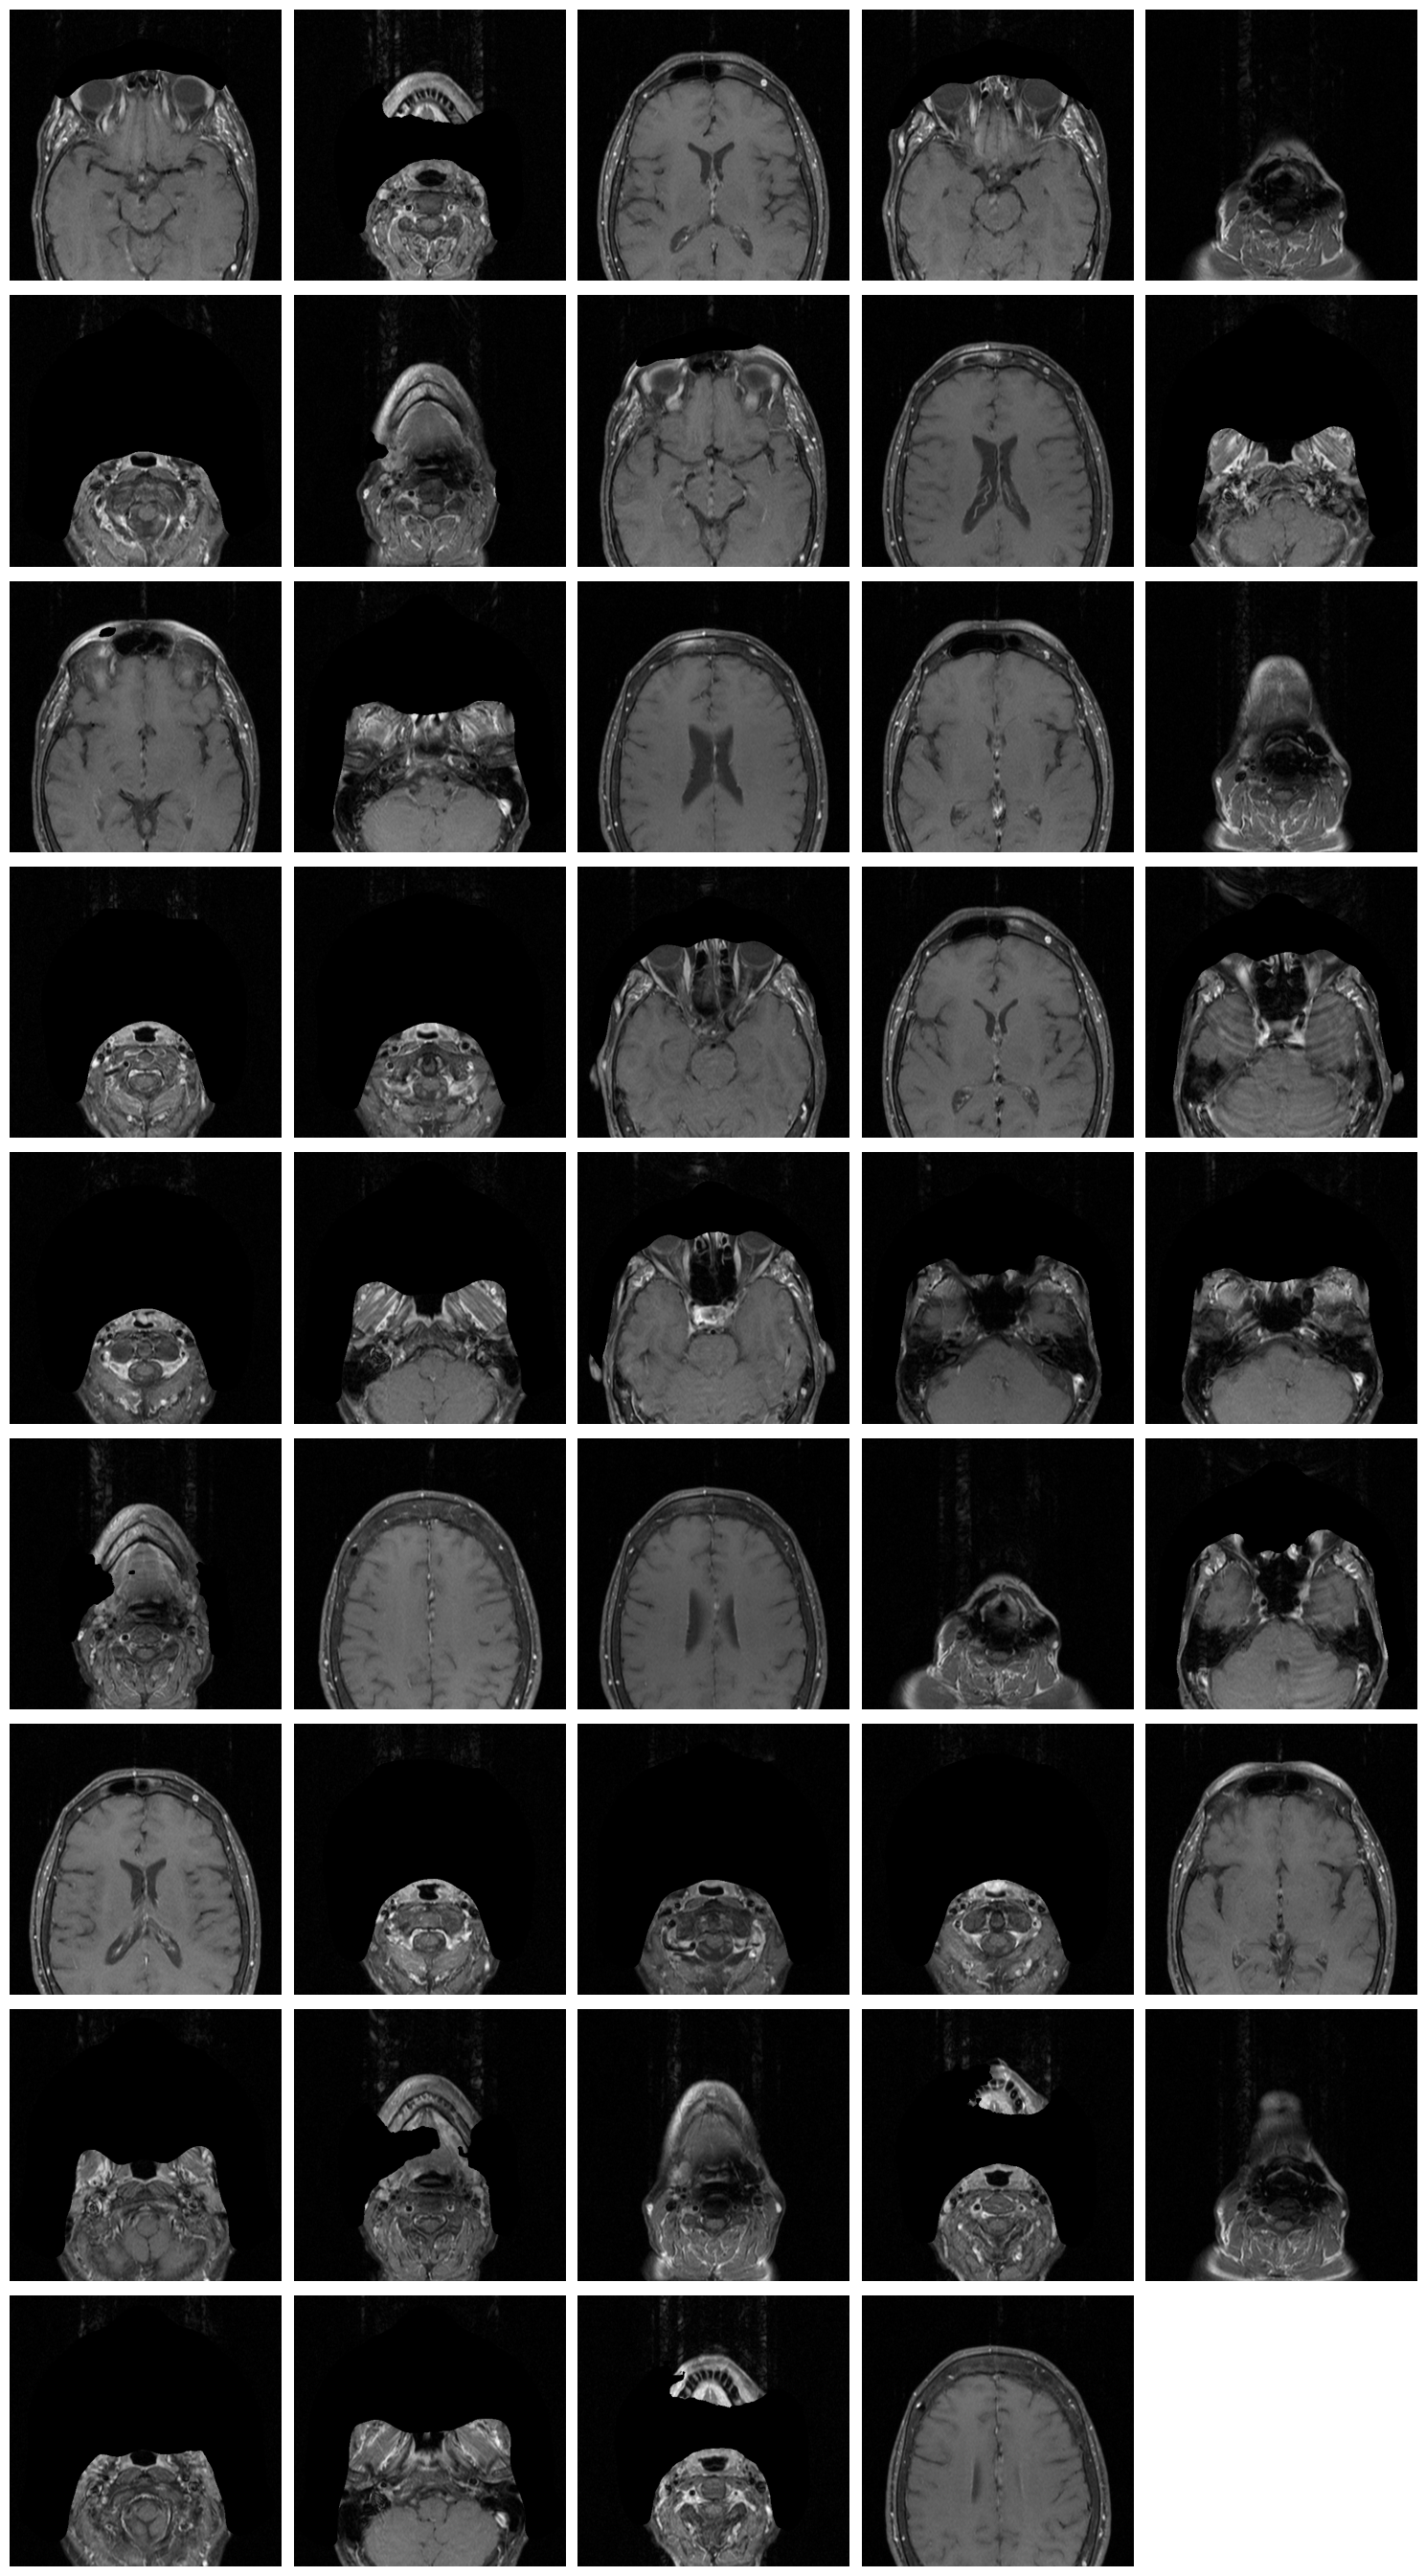

In [10]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Number of images per row in the grid
cols = 5  
rows = int(np.ceil(len(dicom_files) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))

for i, d1 in enumerate(dicom_files):
    dcmread_file = pydicom.dcmread(d1)
    dicom_array = dcmread_file.pixel_array
    float_dicom_array = dicom_array.astype(float)
    positive_dicom_array = np.maximum(float_dicom_array, 0)
    normalized_dicom_array = positive_dicom_array / positive_dicom_array.max()
    normalized_dicom_array *= 255.0
    uint8_image = np.uint8(normalized_dicom_array)

    r, c = divmod(i, cols)
    axes[r, c].imshow(uint8_image, cmap="gray")
    axes[r, c].axis("off")

# Hide any empty subplots (if dicom_files not divisible by cols)
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()

In [11]:
d1 = dicom_files[1]
dcmread_file = pydicom.dcmread(d1)
dicom_array = dcmread_file.pixel_array
float_dicom_array = dicom_array.astype(float)

In [12]:
float_dicom_array

array([[ 0., 24., 32., ..., 16.,  4.,  9.],
       [ 0., 20., 34., ..., 19.,  8.,  4.],
       [ 0., 17., 30., ..., 19.,  6.,  6.],
       ...,
       [ 0., 11., 14., ..., 18., 23., 27.],
       [ 0.,  5., 11., ..., 25., 20., 14.],
       [ 0.,  3., 11., ..., 28., 15.,  6.]])

In [13]:
positive_dicom_array = np.maximum(float_dicom_array, 0)

In [14]:
np.unique(positive_dicom_array)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.052e+03, 1.056e+03,
       1.062e+03])

In [15]:
normalized_dicom_array = positive_dicom_array/positive_dicom_array.max() 
normalized_dicom_array *= 255.0
uint8_image = np.uint8(normalized_dicom_array)

In [16]:
uint8_image

array([[0, 5, 7, ..., 3, 0, 2],
       [0, 4, 8, ..., 4, 1, 0],
       [0, 4, 7, ..., 4, 1, 1],
       ...,
       [0, 2, 3, ..., 4, 5, 6],
       [0, 1, 2, ..., 6, 4, 3],
       [0, 0, 2, ..., 6, 3, 1]], dtype=uint8)

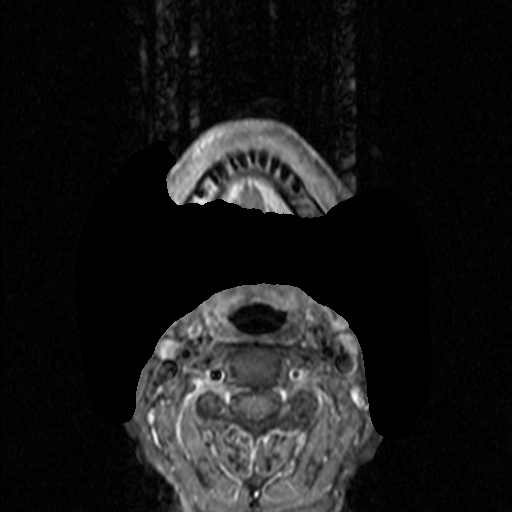

In [17]:
pillow_image = Image.fromarray(uint8_image)
display(pillow_image)

In [18]:
hounsfield_min = np.min(dicom_array)
hounsfield_max = np.max(dicom_array)
hounsfield_range = hounsfield_max - hounsfield_min

In [19]:
dicom_array[dicom_array < hounsfield_min] = hounsfield_min
dicom_array[dicom_array > hounsfield_max] = hounsfield_max
normalized_array_2 = (dicom_array - hounsfield_min) / hounsfield_range
normalized_array_2 *= 255.0
uint8_image = np.uint8(normalized_array_2)

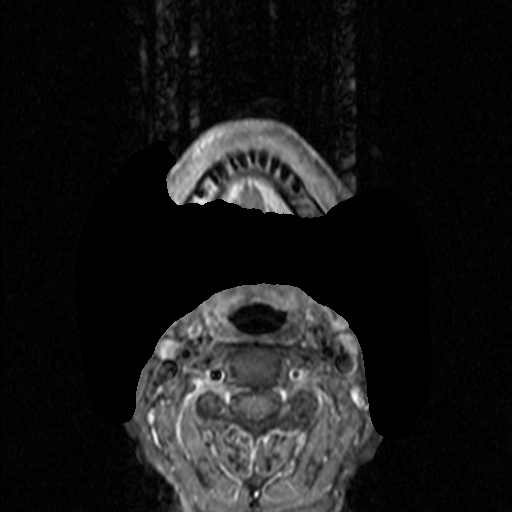

In [20]:
pillow_image = Image.fromarray(uint8_image)
display(pillow_image)

In [21]:
total_cases = train_df["Aneurysm Present"].count()
print("Number of total cases", total_cases)
positive_cases = train_df["Aneurysm Present"].sum()
print("Number of Positive cases", positive_cases)
neg_cases = total_cases - positive_cases
print("Number of Negative Cases:", neg_cases)

Number of total cases 4348
Number of Positive cases 1863
Number of Negative Cases: 2485


In [22]:
import os
from glob import glob
import pydicom
import numpy as np
from PIL import Image

# ✅ Define your main DICOM dataset folder
series_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647'

# ✅ Find all .dcm files (including subfolders)
dicom_files = glob(os.path.join(series_path, '**', '*.dcm'), recursive=True)
print(f"Found {len(dicom_files)} DICOM files.")

# ✅ Create output directory
output_dir = '/kaggle/working/png_output/'
os.makedirs(output_dir, exist_ok=True)

def dicom_to_png(dicom_path, output_path):
    """Convert a DICOM file to a PNG image."""
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(float)
    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)
    Image.fromarray(img_array).save(output_path)

# ✅ Loop through all DICOM files found
for dicom_path in dicom_files:
    filename = os.path.basename(dicom_path).replace('.dcm', '.png')
    output_path = os.path.join(output_dir, filename)
    dicom_to_png(dicom_path, output_path)
    print(f"✅ Converted: {filename}")

print(f"\nAll DICOM files converted successfully! PNGs saved to: {output_dir}")


Found 188 DICOM files.
✅ Converted: 1.2.826.0.1.3680043.8.498.12580127625892711720593425105721678571.png
✅ Converted: 1.2.826.0.1.3680043.8.498.38499074916778076899905126460538333810.png
✅ Converted: 1.2.826.0.1.3680043.8.498.10517225444888619475163956382223622124.png
✅ Converted: 1.2.826.0.1.3680043.8.498.10676452078924881901296423855445745451.png
✅ Converted: 1.2.826.0.1.3680043.8.498.90422058059078394032434504783504864805.png
✅ Converted: 1.2.826.0.1.3680043.8.498.53384850834419901009268505622156934280.png
✅ Converted: 1.2.826.0.1.3680043.8.498.70867576765634456187791966686699326964.png
✅ Converted: 1.2.826.0.1.3680043.8.498.86979701640162311244353465328853309696.png
✅ Converted: 1.2.826.0.1.3680043.8.498.60770159678847176449543892094785010793.png
✅ Converted: 1.2.826.0.1.3680043.8.498.11016739249123368534712543417543889141.png
✅ Converted: 1.2.826.0.1.3680043.8.498.10229246287448303586334999931645148833.png
✅ Converted: 1.2.826.0.1.3680043.8.498.958346877748904987866848187432289613

In [23]:
import shutil
shutil.make_archive("/kaggle/working/dicom_pngs", 'zip', "/kaggle/working/png_output")

'/kaggle/working/dicom_pngs.zip'